# utils

> This module includes utility functions that are used across multiple modules, such as coordinate transformations, interpolation functions, and statistical analysis tools.

In [ ]:
#| default_exp utils

In [ ]:
#| hide
from nbdev.showdoc import *

In [93]:
#| export
from LensCalcPy.parameters import *
import numpy as np
from numpy import pi
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [82]:
#| export

def dist_mw(d: float, # distance from the Sun in kpc
            ) -> float: #distance to the MW center in kpc
    return np.sqrt(d**2 + rEarth**2 - 2*d*rEarth*np.cos(np.radians(l))*np.cos(np.radians(b)))

def dist_m31(d: float, # distance from the Sun in kpc
             ) -> float: #distance to the M31 center in kpc
            return dsM31 - d

def density_mw(r: float, # distance to MW center in kpc
                ) -> float: # DM density in Msun/kpc^3
    return rhoc / ((r/rs) * (1 + r/rs)**2)

def density_m31(r: float, # distance to M31 center in kpc
                ) -> float: # DM density in Msun/kpc^3
    return rhocM31 / ((r/rsM31) * (1 + r/rsM31)**2)

def mass_enclosed_mw(r: float  # distance to MW center in kpc
                      ) -> float : # enclosed DM mass in Msun
    return 4*pi * rhoc * rs**3 * (np.log(1 + r/rs) - (r/rs)/(1 + r/rs))

def mass_enclosed_m31(r: float  # distance to M31 center in kpc
                        ) -> float : # enclosed DM mass in Msun
    return 4*pi * rhocM31 * rsM31**3 * (np.log(1 + r/rsM31) - (r/rsM31)/(1 + r/rsM31))

def velocity_dispersion_mw(r: float, # distance from the MW center in kpc
                        ) -> float: # velocity dispersion in km/s
    return np.sqrt(G * mass_enclosed_mw(r) / r) 

def velocity_dispersion_m31(r: float, # distance from the M31 center in kpc
                        ) -> float: # velocity dispersion in km/s
    return np.sqrt(G * mass_enclosed_m31(r) / r)

def dist(d: float # distance from the Sun in kpc
         ) -> float: #weighted lensing distance in kpc
    return d * (1 - d/ds)

def einstein_rad(d: float, # distance from the Sun in kpc
                 mass: float, # mass of the lens in Msun
                 ) -> float:
    return np.real((4 * G * mass * dist(d)/c**2)**(1/2))


def velocity_radial(d: float, # distance from the Sun in kpc
                    mass: float, # mass of the lens in Msun
                    umin: float, # minimum impact parameter
                    t: float, # crossing time in hours
                    ) -> float: # radial velocity in km/s
    return 2*einstein_rad(d, mass) * (ut**2 - umin**2)**(1/2) / t * kpctokm

# from below 16 of https://iopscience.iop.org/article/10.3847/1538-4357/ac07a8/pdf*)
# alphabar = 27 Degrees xp-axis is aligned with the major axis
# of the Galactic bar,where \[Alpha]bar=27\[Degree] is applied as the bar angle.
# assuming z ~= 0 and we are looking at line of sight to galactic center from Sun
# galactocentric coordniates x', y' as function of d, distance from Sun

def get_primed_coords(d: float # distance from Sun
                      )-> tuple:
    """Get galactocentric coordinates x', y' as function of d, distance from Sun
    """
    x = rEarth - d
    y = 0
    return (x**2 + y**2)**0.5 * np.cos(alphabar*pi/180), (x**2 + y**2)**0.5 * np.sin(alphabar*pi/180)

def scientific_format(x, pos):
    """
    Formats a number in scientific notation in latex
    """
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [139]:
#| export
# Add finite size calculation following https://arxiv.org/pdf/1905.06066.pdf

def w_func(m_pbh, lam):
    return 5.98 * (m_pbh / 1e-10) * (lam / 6210)**(-1)

def magnification(u):
    if u == 0:
        return np.inf
    return (u**2 + 2)/(u*(u**2 + 4)**0.5)

def magnification_wave(w, u):
    return min(magnification(u), pi*w/(1-np.exp(-pi*w)))

def displacement(x, y, u):
    return ((x - u)**2 + y**2)**0.5

def integrand_polar(r, theta, w, u):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return magnification_wave(w, displacement(x, y, u)) * r

def magnification_finite(m_pbh, lam, u, rho):
    w = w_func(m_pbh, lam)
    result, _ = quad(lambda r: quad(lambda theta: integrand_polar(r, theta, w, u), 0, 2*pi)[0], 0, rho)
    return result / (pi * rho**2)

In [141]:
rho = 2
u = 1
m_pbh = 1e-10
lam = 6000

print(magnification_finite(m_pbh, lam, u, rho))

1.375442407351697


In [143]:
us = np.logspace(-3,1,20)
rhos = np.array([0.1, 0.5, 1.0])
mags = np.zeros((len(rhos), len(us)))
for i, rho in enumerate(rhos):
    for j, u in enumerate(us):
        mags[i,j] = magnification_finite(m_pbh, lam, u, rho)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_31755/2342600035.py:25: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(lambda r: quad(lambda theta: integrand_polar(r, theta, w, u), 0, 2*pi)[0], 0, rho)


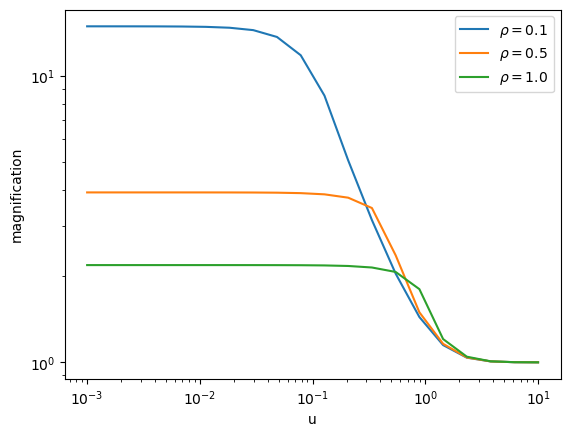

In [144]:
# plt.loglog(us, mags)
for i, rho in enumerate(rhos):
    plt.loglog(us, mags[i,:], label=f'$\\rho = {rho}$')
plt.xlabel('u')
plt.ylabel('magnification')
plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()